# Efficient Frontier

## Two-Assets Efficient Frontier

In [1]:
from alphalib.datasets import load_industry_rets
from alphalib.returns import Returns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize

In [2]:
df = load_industry_rets()

In [3]:
df.columns

Index(['Food', 'Beer', 'Smoke', 'Games', 'Books', 'Hshld', 'Clths', 'Hlth',
       'Chems', 'Txtls', 'Cnstr', 'Steel', 'FabPr', 'ElcEq', 'Autos', 'Carry',
       'Mines', 'Coal', 'Oil', 'Util', 'Telcm', 'Servs', 'BusEq', 'Paper',
       'Trans', 'Whlsl', 'Rtail', 'Meals', 'Fin', 'Other'],
      dtype='object')

In [4]:
rets = df[['Games', 'Fin']]["1996":"2000"]

In [5]:
# Var-Covariance matrix
varcov = rets.cov()
varcov

,Games,Fin
Games,0.003773,0.002416
Fin,0.002416,0.003982


In [6]:
def rand_linspace_weights(n_points):
    w = [(x, 1 - x) for x in np.linspace(0, 1, n_points)]
    return np.array(w)

In [7]:
def rand_weights(n_securities, n_portf=1):
    w = np.random.rand(n_portf, n_securities)
    return w / np.sum(w, axis=1, keepdims=True)

In [8]:
# Weights
weights = rand_linspace_weights(20)
weights

array([[0.        , 1.        ],
       [0.05263158, 0.94736842],
       [0.10526316, 0.89473684],
       [0.15789474, 0.84210526],
       [0.21052632, 0.78947368],
       [0.26315789, 0.73684211],
       [0.31578947, 0.68421053],
       [0.36842105, 0.63157895],
       [0.42105263, 0.57894737],
       [0.47368421, 0.52631579],
       [0.52631579, 0.47368421],
       [0.57894737, 0.42105263],
       [0.63157895, 0.36842105],
       [0.68421053, 0.31578947],
       [0.73684211, 0.26315789],
       [0.78947368, 0.21052632],
       [0.84210526, 0.15789474],
       [0.89473684, 0.10526316],
       [0.94736842, 0.05263158],
       [1.        , 0.        ]])

In [9]:
monthly_rets = (1 + rets).product() ** (1 / len(rets)) - 1
monthly_rets

Games    0.005514
Fin      0.016943
dtype: float64

In [10]:
def portf_return(weights, rets):
    return weights @ rets.T

In [55]:
def portf_vol(weights, varcov):
    if weights.ndim == 1:
        return np.sqrt(weights @ varcov @ weights.T)
    else:
        return np.sqrt(np.multiply(weights @ varcov, weights).sum(axis=1))

In [12]:
p_rets_2 = portf_return(weights, monthly_rets)
p_rets_2

array([0.0169428 , 0.01634129, 0.01573977, 0.01513825, 0.01453673,
       0.01393521, 0.0133337 , 0.01273218, 0.01213066, 0.01152914,
       0.01092762, 0.01032611, 0.00972459, 0.00912307, 0.00852155,
       0.00792003, 0.00731852, 0.006717  , 0.00611548, 0.00551396])

In [13]:
p_vols_2 = portf_vol(weights, varcov)
p_vols_2

0     0.063100
1     0.061845
2     0.060699
3     0.059666
4     0.058753
5     0.057965
6     0.057308
7     0.056786
8     0.056403
9     0.056161
10    0.056063
11    0.056110
12    0.056300
13    0.056633
14    0.057106
15    0.057715
16    0.058457
17    0.059326
18    0.060316
19    0.061423
dtype: float64

In [14]:
p_df_2 = pd.DataFrame({'rets': p_rets_2, 'vol': p_vols_2})

<AxesSubplot:xlabel='vol', ylabel='rets'>

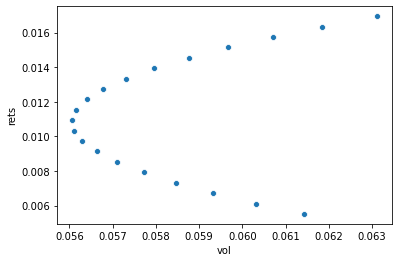

In [15]:
sns.scatterplot(data=p_df_2, x='vol', y='rets')

## N-Assets Efficient Frontier

The following code create N random portfolios.

In [16]:
assets = ['Smoke', 'Rtail', 'Trans']

In [17]:
s_rets = df[assets]['1996':'2000']
s_rets.head()

,Smoke,Rtail,Trans
1996-01,0.0182,-0.0146,-0.0012
1996-02,0.0318,0.0553,0.0418
1996-03,-0.0768,0.0825,0.0326
1996-04,-0.0160,0.0436,0.0265
1996-05,0.0548,0.0511,-0.0028


In [18]:
def rand_portfolios(rets, n_portf=1):
    n_securities = rets.shape[1]
    cov_mat = np.cov(rets.values.T)
    er = (1 + rets).product() ** (1 / len(rets)) - 1
    
    w = rand_weights(n_securities, n_portf)
    p_r = portf_return(w, er)
    p_sigma = portf_vol(w, cov_mat)
    
    return pd.DataFrame({'rets': p_r, 'vol': p_sigma})

In [19]:
p_df = rand_portfolios(s_rets, 1000)

<AxesSubplot:xlabel='vol', ylabel='rets'>

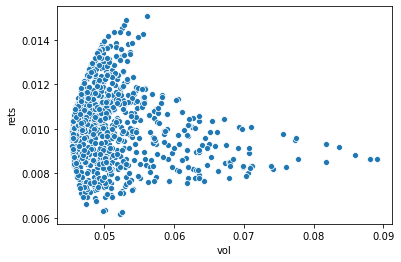

In [20]:
sns.scatterplot(data=p_df, x='vol', y='rets')

## Finding min-variance portfolios

In [69]:
# A function that finds weights of the minimum variance portfolio for a given "target" return
def find_minvar_portf_weights(target, rets):
    n_instruments = rets.shape[1]
    er = (1 + rets).product() ** (1 / len(rets)) - 1
    cov_mat = np.cov(rets.values.T)
    
    # Set bounds for weights
    w_bounds = ((0, 1),) * n_instruments
    
    # Set initial weights
    w_init = np.repeat(1 / n_instruments, n_instruments)
    
    # Set a constraint that weights add up to 1
    c_w_sum1 = {
        'type': 'eq',
        'fun': lambda weights: np.sum(weights) - 1
    }
    
    # Set a constraint that portfolio return matches target return
    c_target_return = {
        'type': 'eq',
        'args': (er,),
        'fun': lambda weights, er: target - portf_return(weights, er)
    }
    
    results = minimize(portf_vol, w_init, args=(cov_mat,), method='SLSQP',
                      options={'disp': False}, constraints=(c_w_sum1, c_target_return),
                      bounds=w_bounds)
    
    return results.x, results.fun, results.success

In [70]:
find_minvar_portf_weights(0.013, s_rets)

(array([0.22443417, 0.65728496, 0.11828086]), 0.04831116862594097, True)

In [71]:
def find_optimal_weights(rets, n_portfolios=50):
    er = (1 + rets).product() ** (1 / len(rets)) - 1
    r_min = er.min()
    r_max = er.max()
    
    p_r = [r for r in np.linspace(r_min, r_max, n_portfolios)]
    p_sigma = [find_minvar_portf_weights(r, rets)[1] for r in p_r]
    
    return pd.DataFrame({'rets': p_r, 'vol': p_sigma})

In [76]:
p_optimal = find_optimal_weights(s_rets, 100)

<AxesSubplot:xlabel='vol', ylabel='rets'>

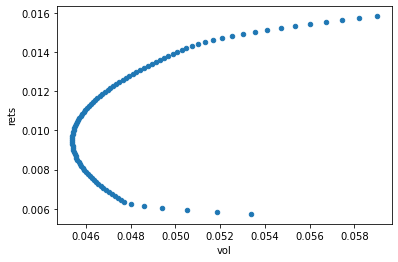

In [77]:
p_optimal.plot.scatter(x='vol', y='rets')